# Transformerによる翻訳処理のサンプル

[言語理解のためのTransformerモデル](https://www.tensorflow.org/tutorials/text/transformer?hl=ja)を参考に，ポルトガル語を英語に翻訳するTransformerの動作確認を行う  
上記は[Apache License 2.0](https://github.com/tensorflow/docs-l10n/blob/master/LICENSE)で配布されており，本ソフトウェアにはその改変物が含まれる

In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf

import time
import numpy as np
import matplotlib.pyplot as plt

from lib.position_encoding import positional_encoding
from lib.masking import create_padding_mask, create_look_ahead_mask
from lib.attention import scaled_dot_product_attention, MultiHeadAttention
from lib.model import point_wise_feed_forward_network, EncoderLayer, DecoderLayer, Encoder, Decoder, Transformer
from lib.trainer import CustomSchedule, train_step, training
from lib.evaluate import translate

## 入力パイプラインの設定

In [2]:
dataset_dir = 'dataset'

In [3]:
!mkdir -p $dataset_dir
!ls

README.md    dataset		docker	translate.ipynb
checkpoints  description.ipynb	lib


In [4]:
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en', with_info=True,
                               as_supervised=True,
                               data_dir=dataset_dir)
train_examples, val_examples = examples['train'], examples['validation']

In [5]:
tokenizer_en = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    (en.numpy() for pt, en in train_examples), target_vocab_size=2**13)

tokenizer_pt = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    (pt.numpy() for pt, en in train_examples), target_vocab_size=2**13)

In [6]:
sample_string = 'Transformer is awesome.'

tokenized_string = tokenizer_en.encode(sample_string)
print ('Tokenized string is {}'.format(tokenized_string))

original_string = tokenizer_en.decode(tokenized_string)
print ('The original string: {}'.format(original_string))

assert original_string == sample_string

Tokenized string is [7915, 1248, 7946, 7194, 13, 2799, 7877]
The original string: Transformer is awesome.


In [7]:
for ts in tokenized_string:
  print ('{} ----> {}'.format(ts, tokenizer_en.decode([ts])))

7915 ----> T
1248 ----> ran
7946 ----> s
7194 ----> former 
13 ----> is 
2799 ----> awesome
7877 ----> .


In [8]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64
MAX_LENGTH = 40

def encode(lang1, lang2):
    lang1 = [tokenizer_pt.vocab_size] + tokenizer_pt.encode(
        lang1.numpy()) + [tokenizer_pt.vocab_size+1]

    lang2 = [tokenizer_en.vocab_size] + tokenizer_en.encode(
        lang2.numpy()) + [tokenizer_en.vocab_size+1]

    return lang1, lang2

def tf_encode(pt, en):
    result_pt, result_en = tf.py_function(encode, [pt, en], [tf.int64, tf.int64])
    result_pt.set_shape([None])
    result_en.set_shape([None])

    return result_pt, result_en

def filter_max_length(x, y, max_length=MAX_LENGTH):
    return tf.logical_and(tf.size(x) <= max_length,
                          tf.size(y) <= max_length)

In [9]:
train_preprocessed = (
    train_examples
    .map(tf_encode) 
    .filter(filter_max_length)
    # 読み取り時のスピードアップのため、データセットをメモリ上にキャッシュする
    .cache()
    .shuffle(BUFFER_SIZE))

val_preprocessed = (
    val_examples
    .map(tf_encode)
    .filter(filter_max_length))

In [10]:
train_dataset = (train_preprocessed
                 .padded_batch(BATCH_SIZE)
                 .prefetch(tf.data.experimental.AUTOTUNE))

val_dataset = (val_preprocessed
               .padded_batch(BATCH_SIZE))

pt_batch, en_batch = next(iter(val_dataset))
pt_batch, en_batch

(<tf.Tensor: shape=(64, 38), dtype=int64, numpy=
 array([[8214,  342, 3032, ...,    0,    0,    0],
        [8214,   95,  198, ...,    0,    0,    0],
        [8214, 4479, 7990, ...,    0,    0,    0],
        ...,
        [8214,  584,   12, ...,    0,    0,    0],
        [8214,   59, 1548, ...,    0,    0,    0],
        [8214,  118,   34, ...,    0,    0,    0]])>,
 <tf.Tensor: shape=(64, 40), dtype=int64, numpy=
 array([[8087,   98,   25, ...,    0,    0,    0],
        [8087,   12,   20, ...,    0,    0,    0],
        [8087,   12, 5453, ...,    0,    0,    0],
        ...,
        [8087,   18, 2059, ...,    0,    0,    0],
        [8087,   16, 1436, ...,    0,    0,    0],
        [8087,   15,   57, ...,    0,    0,    0]])>)

## 位置エンコーディング

(1, 50, 512)


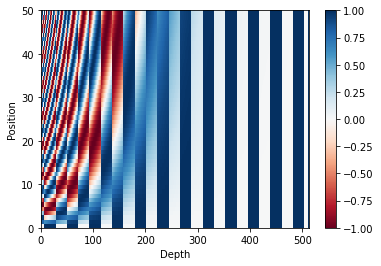

In [11]:
pos_encoding = positional_encoding(50, 512)
print (pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

## マスキング

In [12]:
x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
create_padding_mask(x)

<tf.Tensor: shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)>

In [13]:
x = tf.random.uniform((1, 3))
temp = create_look_ahead_mask(x.shape[1])
temp

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

## スケール済み内積アテンション

In [14]:
def print_out(q, k, v):
  temp_out, temp_attn = scaled_dot_product_attention(
      q, k, v, None)
  print ('Attention weights are:')
  print (temp_attn)
  print ('Output is:')
  print (temp_out)

In [15]:
np.set_printoptions(suppress=True)

temp_k = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[   1,0],
                      [  10,0],
                      [ 100,5],
                      [1000,6]], dtype=tf.float32)  # (4, 2)

# この`query`は2番目の`key`に割り付けられているので
# 2番めの`value`が返される
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


In [16]:
# このクエリは（3番目と 4番目の）繰り返しキーに割り付けられるので
# 関連した全ての値が平均される
temp_q = tf.constant([[0, 0, 10]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)


In [17]:
# このクエリは最初と2番めのキーに等しく割り付けられるので
# それらの値が平均される
temp_q = tf.constant([[10, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.5 0.5 0.  0. ]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[5.5 0. ]], shape=(1, 2), dtype=float32)


In [18]:
temp_q = tf.constant([[0, 0, 10], [0, 10, 0], [10, 10, 0]], dtype=tf.float32)  # (3, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor(
[[0.  0.  0.5 0.5]
 [0.  1.  0.  0. ]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)
Output is:
tf.Tensor(
[[550.    5.5]
 [ 10.    0. ]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)


## マルチヘッド・アテンション

In [19]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 512))  # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(y, k=y, q=y, mask=None)
out.shape, attn.shape

(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

## ポイントワイズのフィードフォワード・ネットワーク

In [20]:
sample_ffn = point_wise_feed_forward_network(512, 2048)
sample_ffn(tf.random.uniform((64, 50, 512))).shape

TensorShape([64, 50, 512])

## エンコーダーとデコーダー

In [21]:
sample_encoder_layer = EncoderLayer(512, 8, 2048)

sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((64, 43, 512)), False, None)

sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)

TensorShape([64, 43, 512])

In [22]:
sample_decoder_layer = DecoderLayer(512, 8, 2048)

sample_decoder_layer_output, _, _ = sample_decoder_layer(
    tf.random.uniform((64, 50, 512)), sample_encoder_layer_output, 
    False, None, None)

sample_decoder_layer_output.shape  # (batch_size, target_seq_len, d_model)

TensorShape([64, 50, 512])

In [23]:
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, input_vocab_size=8500,
                         maximum_position_encoding=10000)
temp_input = tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200)

sample_encoder_output = sample_encoder(temp_input, training=False, mask=None)

print (sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

(64, 62, 512)


In [24]:
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, target_vocab_size=8000,
                         maximum_position_encoding=5000)
temp_input = tf.random.uniform((64, 26), dtype=tf.int64, minval=0, maxval=200)

output, attn = sample_decoder(temp_input, 
                              enc_output=sample_encoder_output, 
                              training=False,
                              look_ahead_mask=None, 
                              padding_mask=None)

output.shape, attn['decoder_layer2_block2'].shape

(TensorShape([64, 26, 512]), TensorShape([64, 8, 26, 62]))

## Transformerの作成

In [25]:
sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048, 
    input_vocab_size=8500, target_vocab_size=8000, 
    pe_input=10000, pe_target=6000)

temp_input = tf.random.uniform((64, 38), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((64, 36), dtype=tf.int64, minval=0, maxval=200)

fn_out, _ = sample_transformer(temp_input, temp_target, training=False, 
                               enc_padding_mask=None, 
                               look_ahead_mask=None,
                               dec_padding_mask=None)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)

TensorShape([64, 36, 8000])

## ハイパーパラメーターの設定

In [26]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8

input_vocab_size = tokenizer_pt.vocab_size + 2
target_vocab_size = tokenizer_en.vocab_size + 2
dropout_rate = 0.1

## オプティマイザー

In [27]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

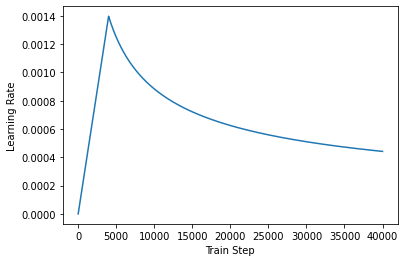

In [28]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

## 損失とメトリクス

※lib/trainer.py内に記述

## 訓練とチェックポイント生成

In [29]:
transformer = training(train_dataset,
        input_vocab_size, target_vocab_size, optimizer,
        num_layers=num_layers,
        d_model=d_model,
        dff=dff,
        num_heads=num_heads,
        dropout_rate=dropout_rate)

Latest checkpoint restored!!
Epoch 1 Batch 0 Loss 0.1719 Accuracy 0.4375


Epoch 1 Batch 50 Loss 0.1671 Accuracy 0.4251
Epoch 1 Batch 100 Loss 0.1684 Accuracy 0.4248
Epoch 1 Batch 150 Loss 0.1692 Accuracy 0.4221
Epoch 1 Batch 200 Loss 0.1695 Accuracy 0.4202
Epoch 1 Batch 250 Loss 0.1721 Accuracy 0.4211
Epoch 1 Batch 300 Loss 0.1735 Accuracy 0.4213
Epoch 1 Batch 350 Loss 0.1746 Accuracy 0.4209
Epoch 1 Batch 400 Loss 0.1761 Accuracy 0.4207
Epoch 1 Batch 450 Loss 0.1773 Accuracy 0.4203
Epoch 1 Batch 500 Loss 0.1788 Accuracy 0.4203
Epoch 1 Batch 550 Loss 0.1807 Accuracy 0.4198
Epoch 1 Batch 600 Loss 0.1823 Accuracy 0.4195
Epoch 1 Batch 650 Loss 0.1839 Accuracy 0.4196
Epoch 1 Batch 700 Loss 0.1857 Accuracy 0.4198
Epoch 1 Loss 0.1857 Accuracy 0.4198
Time taken for 1 epoch: 247.24578094482422 secs

Epoch 2 Batch 0 Loss 0.1616 Accuracy 0.4242
Epoch 2 Batch 50 Loss 0.1613 Accuracy 0.4196
Epoch 2 Batch 100 Loss 0.1640 Accuracy 0.4225
Epoch 2 Batch 150 Loss 0.1672 Accuracy 0.4230
Epoch 2 Batch 200 Loss 0.1685 Accuracy 0.4214
Epoch 2 Batch 250 Loss 0.1709 Accuracy 0.4226

Epoch 11 Batch 450 Loss 0.1667 Accuracy 0.4243
Epoch 11 Batch 500 Loss 0.1675 Accuracy 0.4240
Epoch 11 Batch 550 Loss 0.1689 Accuracy 0.4233
Epoch 11 Batch 600 Loss 0.1701 Accuracy 0.4226
Epoch 11 Batch 650 Loss 0.1714 Accuracy 0.4221
Epoch 11 Batch 700 Loss 0.1730 Accuracy 0.4221
Epoch 11 Loss 0.1731 Accuracy 0.4222
Time taken for 1 epoch: 36.64759588241577 secs

Epoch 12 Batch 0 Loss 0.1665 Accuracy 0.3722
Epoch 12 Batch 50 Loss 0.1589 Accuracy 0.4227
Epoch 12 Batch 100 Loss 0.1568 Accuracy 0.4247
Epoch 12 Batch 150 Loss 0.1581 Accuracy 0.4255
Epoch 12 Batch 200 Loss 0.1601 Accuracy 0.4259
Epoch 12 Batch 250 Loss 0.1608 Accuracy 0.4258
Epoch 12 Batch 300 Loss 0.1623 Accuracy 0.4249
Epoch 12 Batch 350 Loss 0.1631 Accuracy 0.4242
Epoch 12 Batch 400 Loss 0.1645 Accuracy 0.4242
Epoch 12 Batch 450 Loss 0.1661 Accuracy 0.4241
Epoch 12 Batch 500 Loss 0.1677 Accuracy 0.4239
Epoch 12 Batch 550 Loss 0.1692 Accuracy 0.4234
Epoch 12 Batch 600 Loss 0.1704 Accuracy 0.4230
Epoch 12 Batch 650 Loss 0

## 評価

In [30]:
translate(transformer, tokenizer_pt, tokenizer_en, "este é um problema que temos que resolver.")
print ("Real translation: this is a problem we have to solve .")

Input: este é um problema que temos que resolver.
Predicted translation: so this is a problem that we have to solve this technology in terms of doing .
Real translation: this is a problem we have to solve .


In [31]:
translate(transformer, tokenizer_pt, tokenizer_en, "os meus vizinhos ouviram sobre esta ideia.")
print ("Real translation: and my neighboring homes heard about this idea .")

Input: os meus vizinhos ouviram sobre esta ideia.
Predicted translation: my neighbors heard about this idea .
Real translation: and my neighboring homes heard about this idea .


In [32]:
translate(transformer, tokenizer_pt, tokenizer_en, "vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.")
print ("Real translation: so i 'll just share with you some stories very quickly of some magical things that have happened .")

Input: vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.
Predicted translation: so i 'll very quickly share with you a few really magical stories that have happened.c. so they did happen .
Real translation: so i 'll just share with you some stories very quickly of some magical things that have happened .
